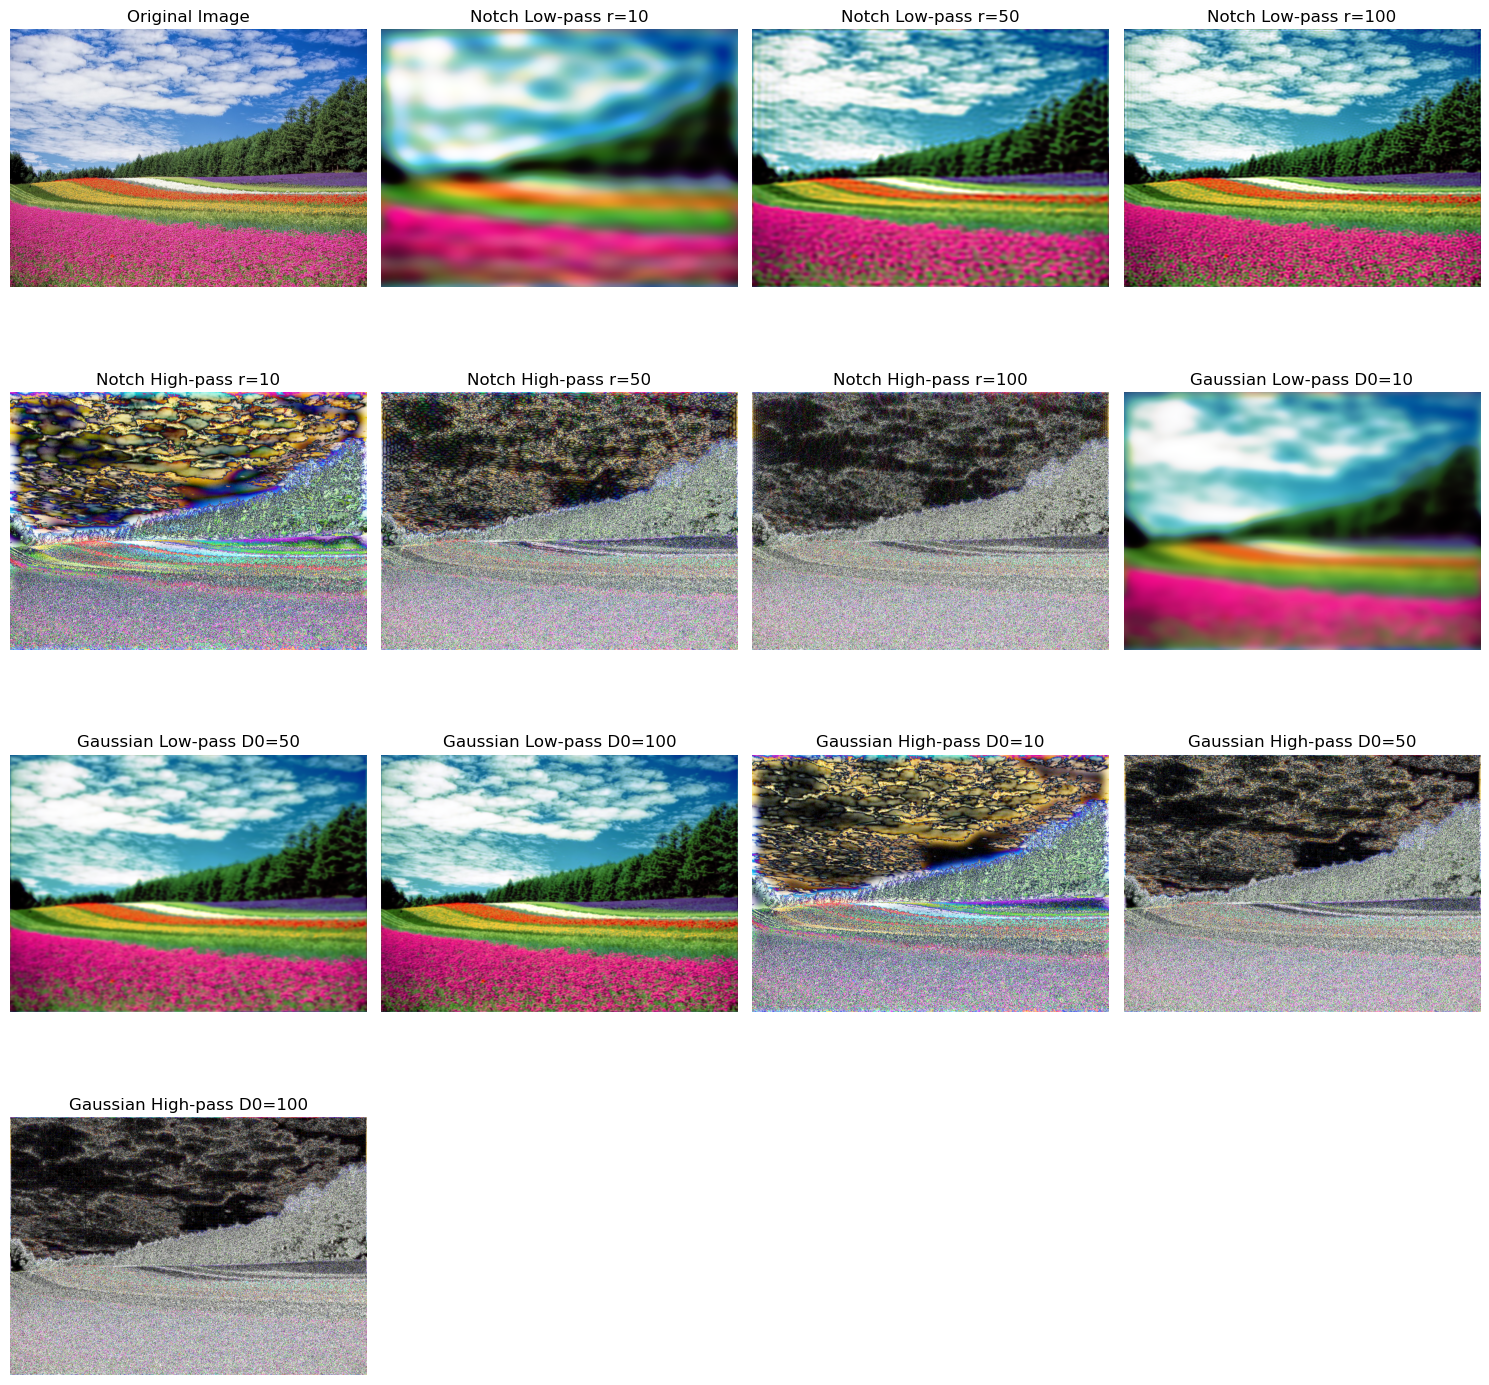

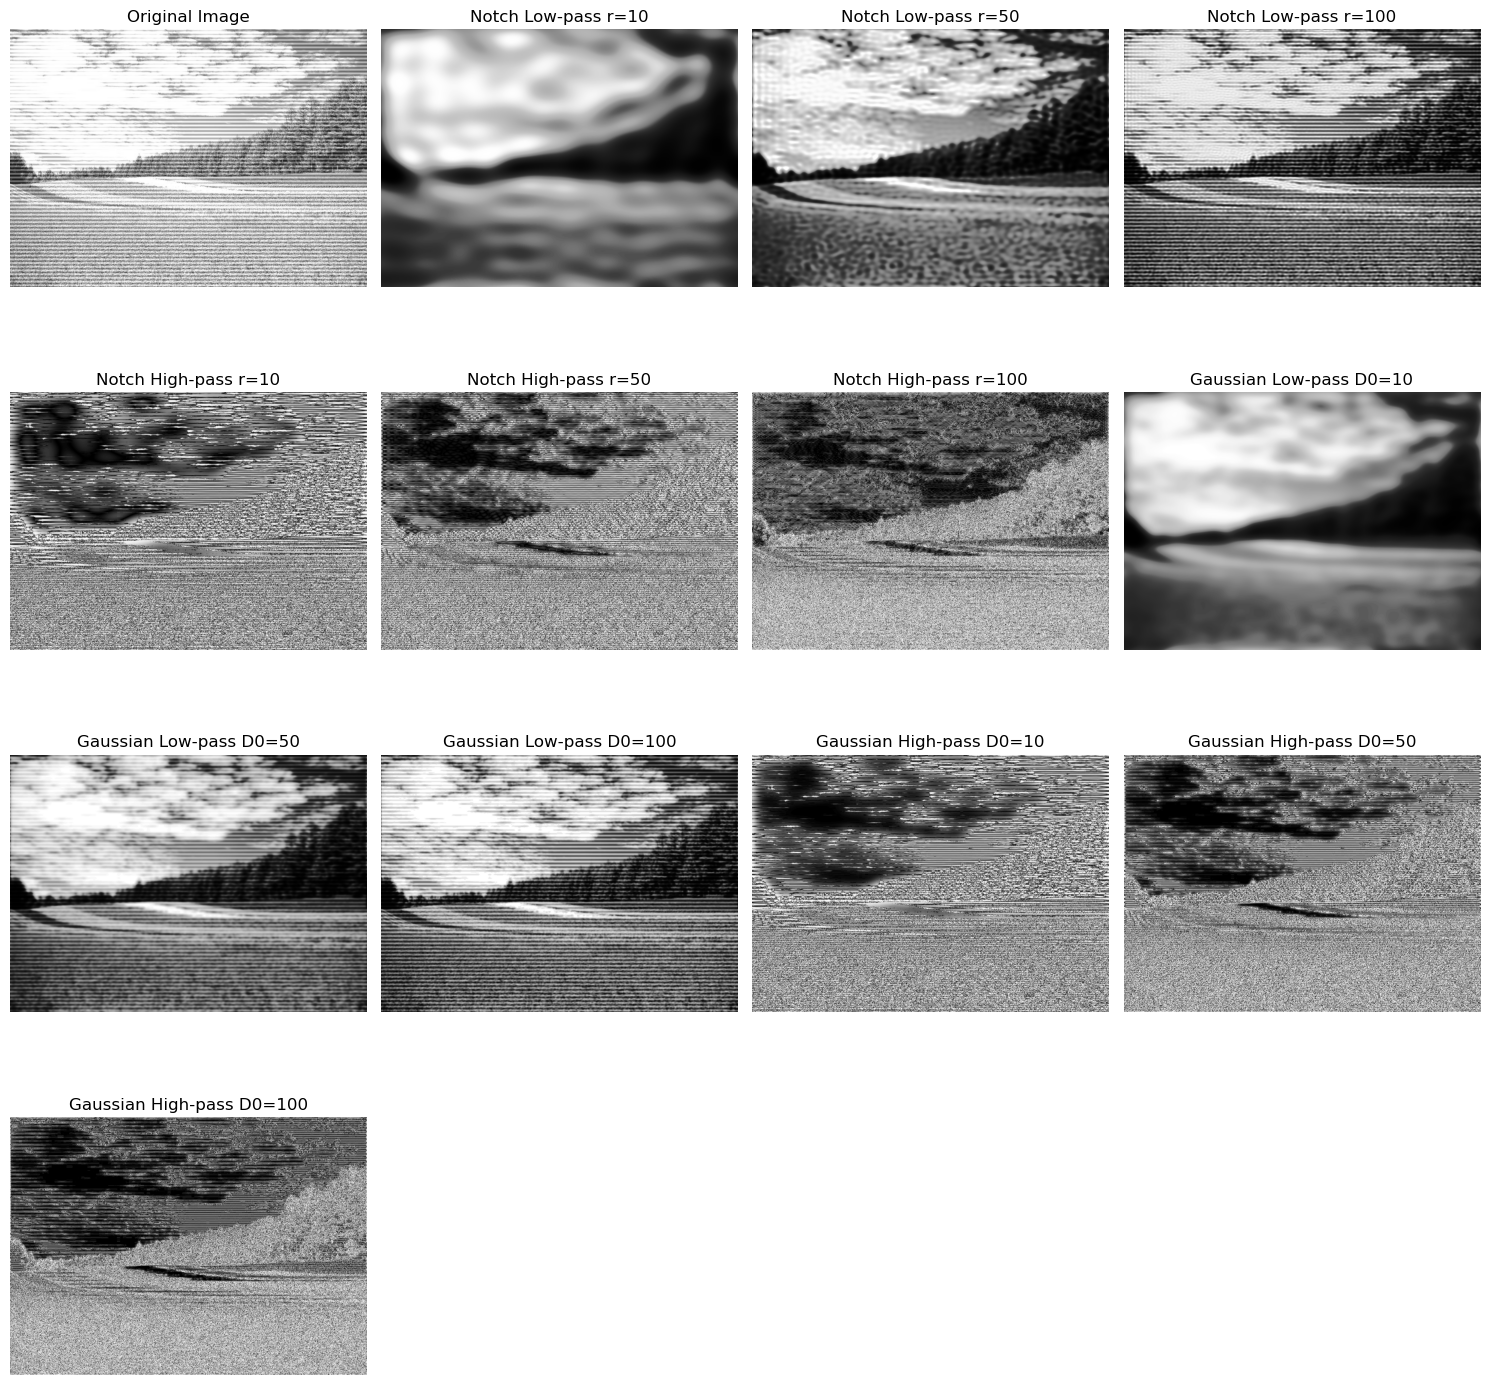

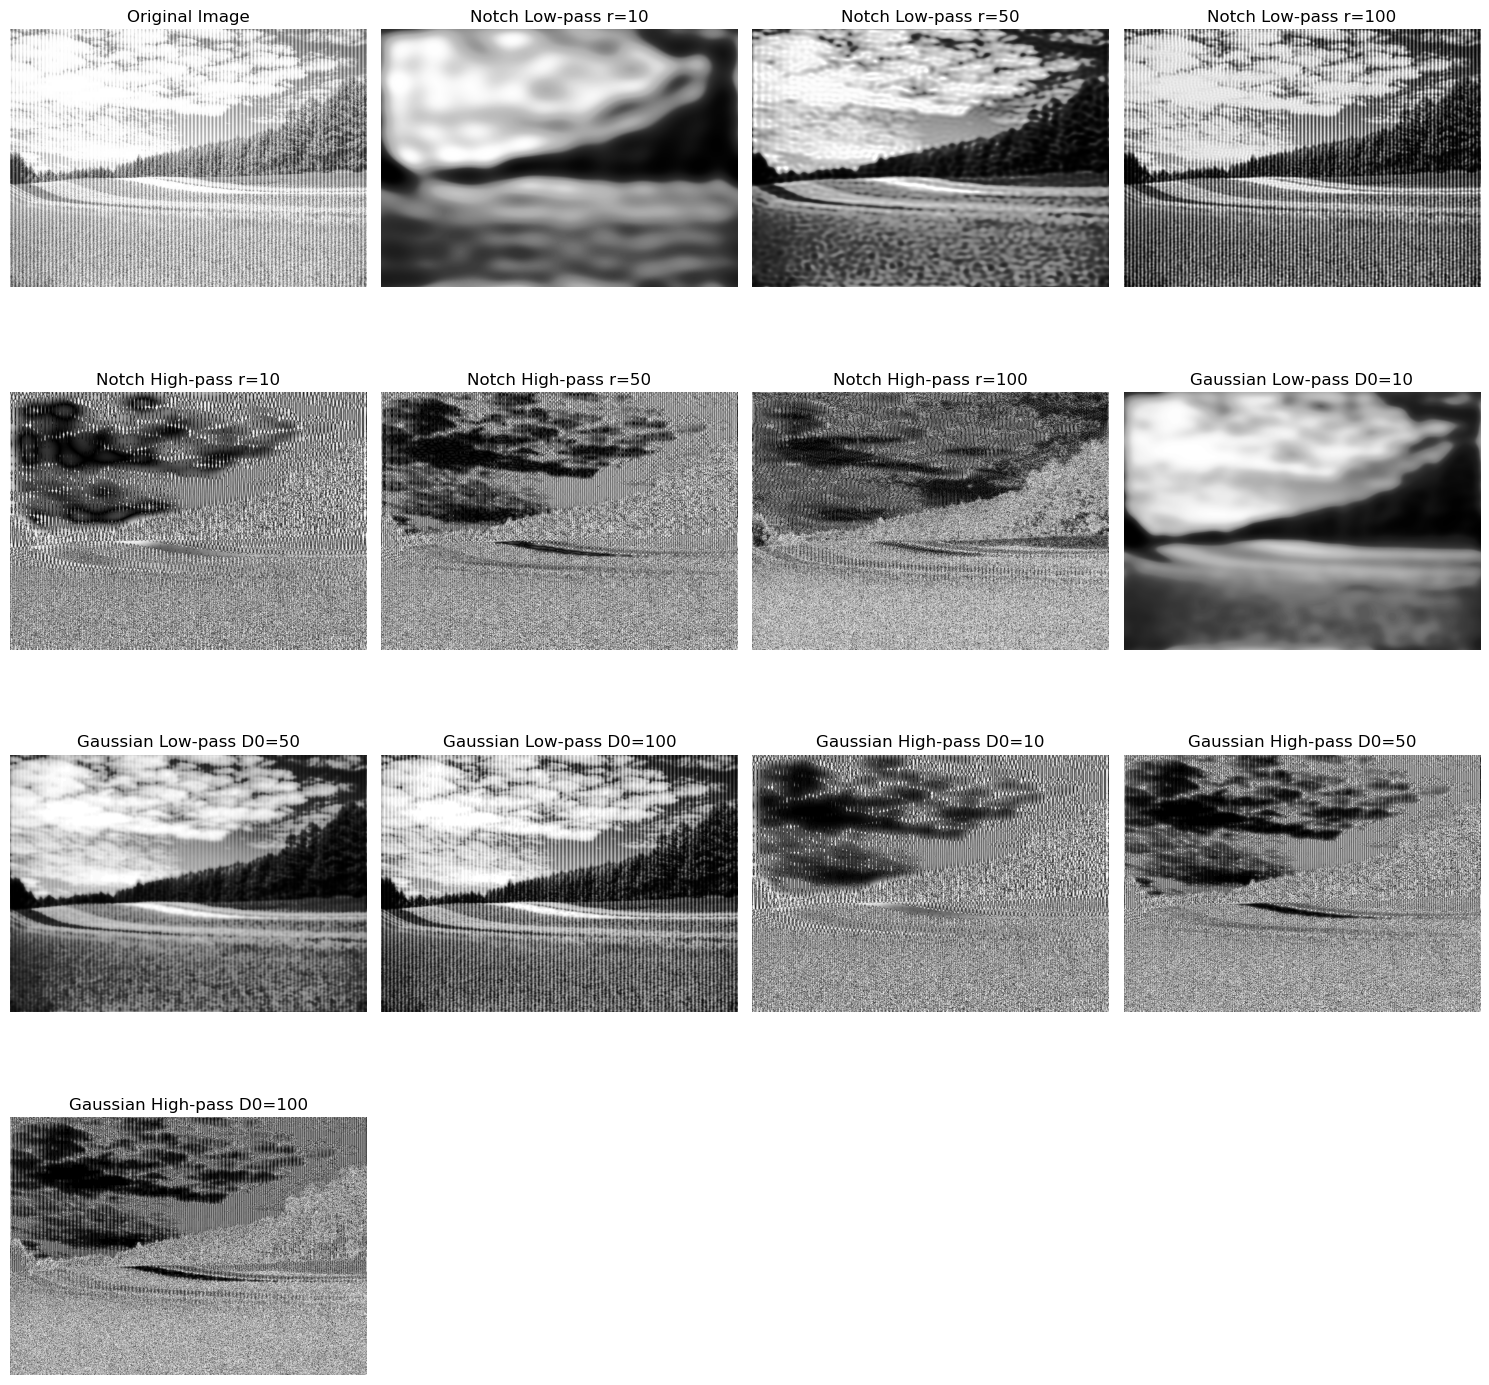

In [15]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def normalize_image(img):
    min_val = np.min(img)
    max_val = np.max(img)
    return ((img - min_val) / (max_val - min_val) * 255).astype(np.uint8)

def fft_display(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    return magnitude_spectrum

def apply_notch_filter(image, filter_type, radius):
    b, g, r = cv2.split(image)
    return cv2.merge([apply_notch_filter_channel(b, filter_type, radius),
                      apply_notch_filter_channel(g, filter_type, radius),
                      apply_notch_filter_channel(r, filter_type, radius)])

def apply_notch_filter_channel(channel, filter_type, r):
    rows, cols = channel.shape
    crow, ccol = rows // 2, cols // 2

    # Calculate FFT and shift zero frequency component to the center
    f = np.fft.fft2(channel)
    fshift = np.fft.fftshift(f)
    
    # Create a mask with the same shape as the channel
    mask = np.ones((rows, cols))

    # Create a notch filter
    for x in range(rows):
        for y in range(cols):
            distance = np.sqrt((x - crow)**2 + (y - ccol)**2)
            if filter_type == "low-pass":
                if distance > r:
                    mask[x, y] = 0
            elif filter_type == "high-pass":
                if distance < r:
                    mask[x, y] = 0

    # Apply the mask and inverse FFT
    fshift = fshift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    enhanced_img = normalize_image(img_back)
    return cv2.equalizeHist(enhanced_img)

def apply_gaussian_filter(image, filter_type, D0):
    b, g, r = cv2.split(image)
    return cv2.merge([apply_gaussian_filter_channel(b, filter_type, D0),
                      apply_gaussian_filter_channel(g, filter_type, D0),
                      apply_gaussian_filter_channel(r, filter_type, D0)])

def apply_gaussian_filter_channel(channel, filter_type, D0):
    rows, cols = channel.shape
    crow, ccol = rows // 2, cols // 2

    # Calculate FFT and shift zero frequency component to the center
    f = np.fft.fft2(channel)
    fshift = np.fft.fftshift(f)

    # Create a mask with the same shape as the channel
    mask = np.ones((rows, cols))
    
    # Create a Gaussian filter
    for x in range(rows):
        for y in range(cols):
            distance = np.sqrt((x - crow)**2 + (y - ccol)**2)
            if filter_type == "low-pass":
                mask[x, y] = np.exp(-(distance**2) / (2 * (D0**2)))
            elif filter_type == "high-pass":
                mask[x, y] = 1 - np.exp(-(distance**2) / (2 * (D0**2)))

    # Apply the mask and inverse FFT
    fshift = fshift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    enhanced_img = normalize_image(img_back)
    return cv2.equalizeHist(enhanced_img)

images = ["../original_images/flower1.jpg",
          "../original_images/Noisy_flower1_horizontal.jpg", 
          "../original_images/Noisy_flower1_vertical.jpg"]

radii = [10, 50, 100]
cutoffs = [10, 50, 100]
base_output_dir = './OUTPUT'
if not os.path.exists(base_output_dir):
    os.mkdir(base_output_dir)
    
for img_path in images:        
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    
    img_name = os.path.basename(img_path).split('.')[0]
    img_output_dir = os.path.join(base_output_dir, img_name)
    if not os.path.exists(img_output_dir):
        os.mkdir(img_output_dir)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(4, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Save original image to OUTPUT directory
    plt.imsave(os.path.join(img_output_dir, f'{img_name}_original.png'), img)

    notch_dir = os.path.join(img_output_dir, 'notch')
    if not os.path.exists(notch_dir):
        os.mkdir(notch_dir)

    for i, r in enumerate(radii, 2):
        denoised_notch_low = apply_notch_filter(img, "low-pass", r)
        plt.subplot(4, 4, i)
        plt.imshow(denoised_notch_low, cmap='gray')
        plt.title(f'Notch Low-pass r={r}')
        plt.axis('off')
        plt.imsave(os.path.join(notch_dir, f'{img_name}_lowpass_r{r}.png'), denoised_notch_low)

    for i, r in enumerate(radii, 5):
        denoised_notch_high = apply_notch_filter(img, "high-pass", r)
        plt.subplot(4, 4, i)
        plt.imshow(denoised_notch_high, cmap='gray')
        plt.title(f'Notch High-pass r={r}')
        plt.axis('off')
        plt.imsave(os.path.join(notch_dir, f'{img_name}_highpass_r{r}.png'), denoised_notch_high)

    gaussian_dir = os.path.join(img_output_dir, 'gaussian')
    if not os.path.exists(gaussian_dir):
        os.mkdir(gaussian_dir)

    for i, D0 in enumerate(cutoffs, 8):
        denoised_gaussian_low = apply_gaussian_filter(img, "low-pass", D0)
        plt.subplot(4, 4, i)
        plt.imshow(denoised_gaussian_low, cmap='gray')
        plt.title(f'Gaussian Low-pass D0={D0}')
        plt.axis('off')
        plt.imsave(os.path.join(gaussian_dir, f'{img_name}_lowpass_D0{D0}.png'), denoised_gaussian_low)

    for i, D0 in enumerate(cutoffs, 11):
        denoised_gaussian_high = apply_gaussian_filter(img, "high-pass", D0)
        plt.subplot(4, 4, i)
        plt.imshow(denoised_gaussian_high, cmap='gray')
        plt.title(f'Gaussian High-pass D0={D0}')
        plt.axis('off')
        plt.imsave(os.path.join(gaussian_dir, f'{img_name}_highpass_D0{D0}.png'), denoised_gaussian_high)

    plt.tight_layout()
    plt.show()